# Connected and Autonomous Driving - Visual Perception Assignment: Image Classification
Lab Author: [François Robinet](mailto:francois.robinet@uni.lu)

----

In this assignment, we will learn how to tackle the complex problem of classifying traffic signs. These signs come in many shapes, colors and forms, and it is hard even for us to express how exactly we identify traffic signs. This makes learning from actual data an ideal fit for this problem!

The following concepts will be covered in this Lab:

1. Loading data in a format suitable for learning algorithms
1. Implementation of a Softmax Classifier in plain PyTorch
1. Performance assessment in machine learning
1. GPU Implementation of complex classification models using PyTorch
1. Regularization in the context of neural networks (data augmentation, dropout, early stopping)

In this lab, we will leverage the GPU capabilities of Google Colab. To enable a GPU for this notebook, go to "Execution > Change Execution Type" and add GPU capabilities. Executing the next cell should succeed and show one available GPU.


In [3]:
! nvidia-smi

Thu Dec 21 20:01:19 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0              28W /  70W |    105MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Introduction to scientific computing in Python

The practical sessions of this class assume some basic familiarity with Python, Jupyter Notebooks, and the NumPy ecosystem.

For an excellent introduction to these concepts, see [the following introductory notebook from Stanford University](https://drive.google.com/file/d/1iQ6yZ3R_SaMCbAUUkwarOk-iFPywQ4-7/view?usp=sharing).

If you have used Numpy/Matplotlib before, you should feel right at home!


## Loading Traffic Sign Data

This cell will download the traffic sign data used for this assignment.



In [4]:
from pathlib import Path
print(f"Downloading and extracting the traffic sign dataset")
FILEID="1ALQlcJo-F2mRKnACEG5xkGkU-lzsdBN7"
FILENAME="traffic_signs.zip"
! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILEID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILEID" -O $FILENAME && rm -rf /tmp/cookies.txt
traffic_signs_dir = Path("/content") / "traffic_signs_data"
traffic_signs_dir.mkdir(parents=True, exist_ok=True)
! unzip $FILENAME -d $traffic_signs_dir

--2023-12-21 20:01:20--  https://docs.google.com/uc?export=download&confirm=&id=1ALQlcJo-F2mRKnACEG5xkGkU-lzsdBN7
Resolving docs.google.com (docs.google.com)... 142.251.31.138, 142.251.31.102, 142.251.31.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.31.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2eteqtepmgrj1rpin73daf99mqi7q5as/1703188875000/10412813601786275186/*/1ALQlcJo-F2mRKnACEG5xkGkU-lzsdBN7?e=download&uuid=855ba71a-f820-4e35-969e-86b478460e5f [following]
--2023-12-21 20:01:20--  https://doc-0o-70-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/2eteqtepmgrj1rpin73daf99mqi7q5as/1703188875000/10412813601786275186/*/1ALQlcJo-F2mRKnACEG5xkGkU-lzsdBN7?e=download&uuid=855ba71a-f820-4e35-969e-86b478460e5f
Resolving doc-0o-70-docs.googleusercontent.com (doc-0o-70-docs.googleusercontent.com)... 173.194.69.132, 2

The traffic sign data is split into train / validation / test datasets.
Each of this dataset has can be loaded directly using `numpy.load`.

The data contains the following data for the traffic signs:

- `features`: the traffic sign 32x32 3-channel RGB images
- `labels`: a single label for each sample, represented as a number in [0,42]. These numbers relate to each of the 43 traffic signs names that are read from  `signnames.csv`.

Let's load the 34799 samples of the training set and display a 16 random images with their labels.


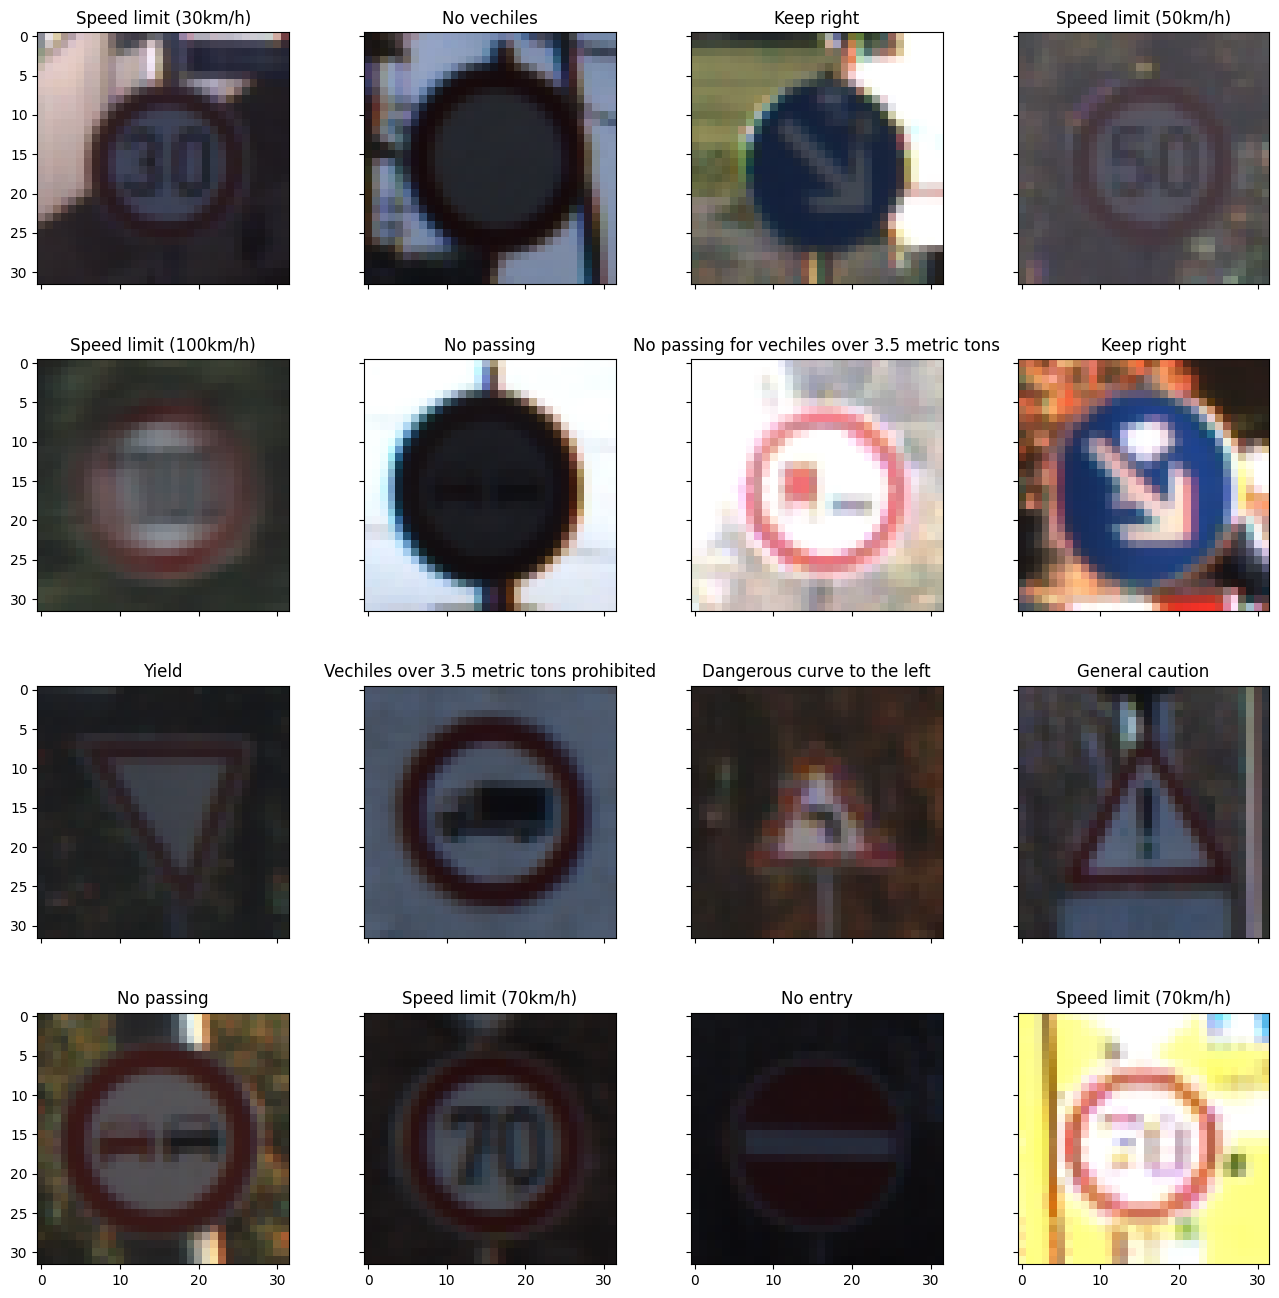

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

def load_data(path):
  data = np.load(path, allow_pickle=True)
  images, labels = data["features"], data["labels"]
  # Pixels are stored as unsigned integers in [0,255]
  # Because our numerical operations treat these as floating point numbers,
  # it's best to convert these numbers to float and map them to [0,1]
  images = images.astype(np.float32) / 255.0
  labels = labels.astype(np.int64)
  return images, labels

def show_image_grid(images, titles):
  fig = plt.figure(figsize=(16,16))
  ncols = 4
  nrows = int(np.ceil(images.shape[0] // ncols))
  grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=0.75)
  for ax, img, title in zip(grid, images, titles):
    ax.imshow(img)
    ax.set_title(title)

# Read data
sign_names = pd.read_csv(traffic_signs_dir / "signnames.csv").SignName.values
training_images, training_labels = load_data(traffic_signs_dir / "train.p")
training_size = training_labels.shape[0]

# Display 16 random images with their labels
random_indices = np.random.choice(np.arange(training_size), size=16, replace=False)
show_image_grid(training_images[random_indices], sign_names[training_labels[random_indices]])


## Classification with a Single Layer: Logistic/Softmax Regression

### Model

Our first approach will be to implement a simple linear classifier using numpy only. This means that our output will be predicted as

$$\hat{y} = \sigma(Wx+b)$$

where

- $x$ is a vector image pixel values. Shape is $(3*32*32,) = (3072,)$.
- $\hat{y}$ is a $(43,)$ shaped vector containing a probability value for each class.
- $W$ is a (43,3072) matrix of weights to be learned. The weights will be initialized to random numbers in $[0,1]$. More advanced strategies exist and will be covered in the next parts.
- $b$ is a vector of weights called the biases, that will also be learned. Its shape is $(43,)$
- $\sigma$ is the softmax activation function which will project values in $Wx$ into $[0,1]$ and make them sum to one: $\sigma(x)_i = \frac{e^{x_i}}{\sum_je^{x_j}}$.



### From Theory to Practice: Implementing the model

Let's now implement our softmax classifier in PyTorch. We can easily do so by creating a new class deriving from `torch.nn.Module` and implementing the computation in its `forward` method. You'll learn more about why this is called `forward` next week.

If you want to show the documentation relative to a function like `torch.nn.Parameter`, just execute the following code in a cell and documentation will pop-up.

```
torch.nn.Parameter?
```


In [6]:
import torch
from torch import nn
import torch.nn.functional as F

class SoftmaxClassifier(nn.Module):
  def __init__(self):
    super().__init__() # Mandatory: PyTorch does some setting up in there!
    # Create our weight Tensor W. It will be of type float and have shape (1,43,3*32*32)
    # The extra first dimension is there because nn.Modules ar emeant to process
    # batches of inputs, and the inputs after reshaping will have shape (B, 3072, 1),
    # where B is the batch size. Adding an extra dimension is needed for numpy
    # to broadcast the first dimension of our weights to B.
    W_shape = (1, 43, 3*32*32) # TODO
    bias_shape = (43, 1) # TODO
    # Since we want to learn these weights, we will create them as "parameters" (another name for weights)
    # Initialize parameters with random numbers in [0,1] (biases can be initialized to zero)
    # Better init stategies exist and will be covered later on
    self.W = nn.Parameter(torch.Tensor(*W_shape))
    nn.init.uniform_(self.W, 0.0, 1.0)
    self.bias = nn.Parameter(torch.zeros(bias_shape))

  def forward(self, x):
    # The formula treats x as a vector, but we're receiving a batch of images
    # with shape (B,32,32,3), which we reshape to (B,32*32*3,1).
    x = x.view(x.shape[0],-1,1)
    # TODO: Compute our prediction y_hat following the formula in the description above
    # Hint: the softmax function is available as torch.nn.functional.softmax (here F.softmax)
    # Keep in mind that you want to compute the softmax separately on each image,
    # so no softmax on dim 0!
    y_hat = F.softmax(self.W @ x + self.bias, dim=1) # TODO
    return torch.squeeze(y_hat) # Squeeze removes any extra dimension with value 1, so we're back to (B,43) shape

# Create our classifier
softmax_classifier = SoftmaxClassifier()

### Our very first prediction

We have a randomly intialized model, let's use it to make a prediction on a random batch of images!

Remember that we are predicting 43 numbers for each image, which according to our model can be interpreted as the probability of each class to be the "right one". To get an actual prediction, we can simply grab the class with maximal probability.

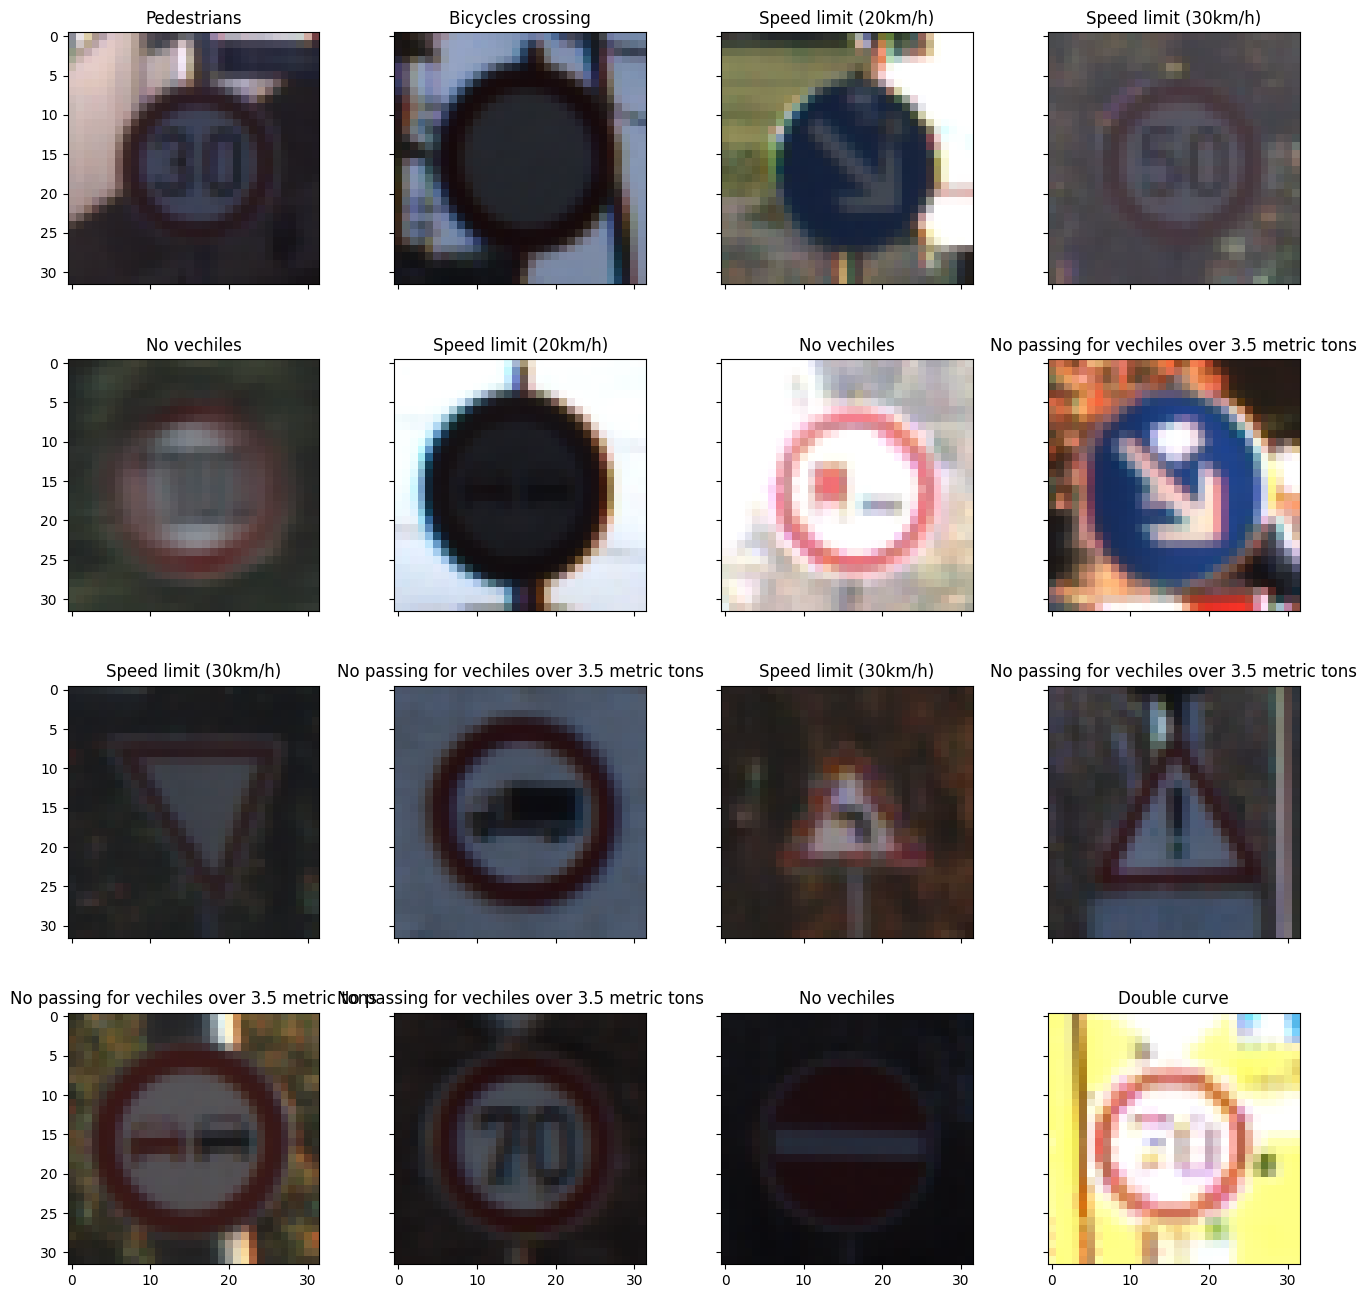

In [7]:
# We will reuse the random batch of 16 images we showed when loading the data
input_images = torch.from_numpy(training_images[random_indices]) # This has shape (16,32,32,3)
with torch.no_grad(): # Don't worry about no_grad for now, it just means we're not trying to optimize anything
  # TODO: Compute class probabilities by feeding the random_batch to your model (just a function call like "model(x)")
  y_pred = softmax_classifier.forward(input_images) # Class probabilities
  assert y_pred.shape == (input_images.shape[0],sign_names.shape[0]), f"Predicted shape should be {(input_images.shape[0],sign_names.shape[0])} and is {y_pred.shape}."

# TODO: Find the most probable label for each image according to our model
# Hint: torch.argmax should help you there, just keep in mind that you want the max *per-image* (so don't argmax on dimension 0)
predicted_labels = torch.argmax(y_pred, dim=1) # Most probable label for each image
assert predicted_labels.shape == (input_images.shape[0],), f"Predicted labels shape should be {(input_images.shape[0],)} and is {predicted_labels.shape}"
predicted_sign_names = sign_names[predicted_labels]

# Show the image and their predicted class
show_image_grid(input_images, predicted_sign_names)

### Training our Model

Our first prediction is rather... disappointing. It's not surprising though: we've learned a lot, but our model hasn't and it's predicting at random, often choosing the same class for most inputs! Let's see if we can fix this!

#### Loss Function

We first transform each ground truth label into a one-hot encoded vector

$$
\begin{equation}
  y_i=\begin{cases}
    1 & \text{if sample has class } i\\
    0 & \text{otherwise}.
  \end{cases}
\end{equation}
$$

We want to make $\hat{y}$ close to the ground truth $y$, which can be done in several ways. For multinomial classification, it is very common to use the "Negative Log-Likelihood Loss" we covered in class. In PyTorch, this loss function $L(y,\hat{y})$ is implemented in `torch.nn.NLLLoss`.


#### Stochastic Gradient Descent

Stochastic Gradient Descent iteratively updates the weights in order to minimize $L(\hat{y},y)$. Remember that $L$ depends on the weights because each prediction $\hat{y} = \sigma(Wx+b)$ depends on them.

We seek to compute the optimal weights $W^*$ such that

$$W^* = \underset{W,b}{\mathrm{argmin}}\ L(\sigma(Wx+b),y)$$

Gradient-based optimization iteratively improves on weight estimates $(W_k, W_{k+1}, ...)$ and $(b_k, b_{k+1}, ...)$ by making steps in the direction opposite to the gradient/jacobian directions

\begin{equation}
\begin{cases}
    W_{k+1} &= W_k - \alpha \nabla_W L\\
    b_{k+1} &= b_k - \alpha \nabla_b L
\end{cases}
\end{equation}

Where $\alpha$ defines a "step size", usually refered to as "learning rate" in machine learning. There are also more fancy ways to update parameters at each iteration, and we will discuss these in later classes.

Computing $\nabla_W L$ and $\nabla_b L$ is not trivial and will be covered in later classes.
One of the primary reasons for using Deep Learning frameworks like PyTorch or Tensorflow is that they will compute these for us!


  0%|          | 0/110 [00:00<?, ?it/s]

Text(0, 0.5, 'Training Loss')

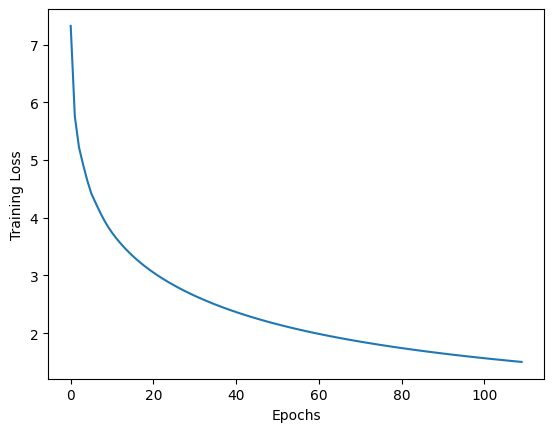

In [8]:
from tqdm.notebook import tqdm # We'll use this for nice progress bars

# Training Loop:
#   - separate the training data into batches of 64 samples
#   - each epoch goes over all the batches in the dataset, and we can repeat the process for many epochs
#   - we feed each batch to our model, compute a loss, compute its gradient, and perform an SGD update
batch_size = 256
#num_epochs = 5
num_epochs = 110
learning_rate = 5e-3
batches_per_epoch = int(np.ceil(training_images.shape[0] / batch_size))
loss_function = torch.nn.NLLLoss() # Negative Log-Likelihood loss function (aka cross-entropy loss)

#softmax_classifier = SoftmaxClassifier()
softmax_classifier = SoftmaxClassifier().cuda()
softmax_classifier.train()
epoch_losses = []
pbar = tqdm(range(num_epochs))
for epoch in pbar:
  average_epoch_loss = 0 # Running average loss over epoch
  for batch_idx in range(batches_per_epoch):
    # Get batch of training data
    batch_start_index = batch_size * batch_idx
    batch_images = torch.from_numpy(training_images[batch_start_index:batch_start_index+batch_size])
    batch_images = batch_images.cuda()
    batch_labels = torch.from_numpy(training_labels[batch_start_index:batch_start_index+batch_size])
    batch_labels = batch_labels.cuda()

    # TODO: Feed images to the model
    class_probabilities = softmax_classifier(batch_images)

    # Compute loss value using NLLLoss
    # NLLLoss expects log-probabilities rather than probabilities
    # NLLLoss will also handle converting ground truth labels to one-hot encoded vectors
    class_log_probabilities = torch.log(class_probabilities+1e-7) # 1e-7 added for numerical stability
    loss = loss_function(class_log_probabilities, batch_labels)

    # Print loss information so we can monitor training
    average_epoch_loss = (batch_idx * average_epoch_loss + loss.item()) / (batch_idx+1)

    # Compute the gradient of the loss wrt. to model parameters
    loss.backward() # The reason why this is called "backward" will become clear after the next class

    # TODO: Implement SGD update
    # After the call to loss.backward, the gradient of the loss with respect to parameter w is `w.grad`
    # You can access all the model's parameters with `softmax_classifier.parameters()` and loop over them to update them
    with torch.no_grad(): # Loop wrapped in no_grad again because we don't need to accumulate gradients for this step
      for p in softmax_classifier.parameters():
        p -= p.grad * learning_rate # TODO SGD Update
        # *important*: by default PyTorch remembers gradients from previous iterations, so we always have to zero them out before next iteration
        p.grad.zero_()
  epoch_losses.append(average_epoch_loss)
  pbar.set_description(f"Last Epoch Loss: {average_epoch_loss:.4f}")

# Plot training loss evolution
plt.plot(epoch_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")

### CUDA to the Rescue

Our model is learning, but it's pretty slow, taking upward of 15s for each epoch. We can speed this up tremendously by leveraging the GPU. Indeed, Matrix multiplication is at the heart of our model, and is the type of heavily parallelizable operation that GPUs are extremely efficient at.

PyTorch makes moving this kind of computation to the GPU extremely easy. Modify the above code cell to

- Move your model to GPU memory: `softmax_classifier = SoftmaxClassifier().cuda()`
- Move your inputs to GPU memory: `batch_images = batch_images.cuda()`, `batch_labels = batch_labels.cuda()`
- Crank up the number of epochs: `num_epochs = 100`

To bring a GPU Tensor back to CPU RAM, we can simply use `tensor.cpu()`.

Run again, and enjoy the free speedup!

## Assessing Multinomial Classification Models

### Why bother with a test set?

The training loss informs us that the model is training, but it does not give us much information about the inference performance of that model. Indeed training metrics have no value when assessing generalization performance. To covince yourself of that fact, imagine a model that simply memorizes the training set entirely. This model is trivial to implement, it will have 0 training loss, but will be utterly useless to make predictions on unseen data!

To assess the generalization abilities, one should use a separate split of the data called the test set. This split of the data must never be used during training, and can only be used after the fact in order to estimate the performance of the trained model on unseen data. As much as possible, this test set should be representative of the data that would be encountered in the real-world application. This is also true for the training set of course!

Let's start assessing our model by computing the simplest classification metric: accuracy!

In [9]:
# Load the test data
from sklearn.metrics import accuracy_score
from typing import Dict, Callable
from tqdm.notebook import tqdm

def eval_metrics(model, dataset_images, dataset_labels, batch_size, metrics_fns: Dict[str,Callable], desc=None):
  model.eval()
  total_batches = int(np.ceil(dataset_images.shape[0] / batch_size))
  with torch.no_grad():
    pred_labels = []; true_labels = []
    for batch_idx in tqdm(range(total_batches), desc=desc):
      batch_start_index = batch_idx * batch_size
      batch_images = torch.from_numpy(dataset_images[batch_start_index:batch_start_index+batch_size]).cuda()
      batch_labels = torch.from_numpy(dataset_labels[batch_start_index:batch_start_index+batch_size]).cuda()
      class_probabilities = model(batch_images)
      predicted_labels = torch.argmax(class_probabilities, dim=1)
      pred_labels.append(predicted_labels.cpu().numpy())
      true_labels.append(batch_labels.cpu().numpy())
  pred_labels = np.hstack(pred_labels)
  true_labels = np.hstack(true_labels)
  return { name: metric(true_labels, pred_labels) for name, metric in metrics_fns.items() }

test_images, test_labels = load_data(traffic_signs_dir / "test.p")
training_metrics = eval_metrics(softmax_classifier, training_images, training_labels, 256, {"accuracy": accuracy_score}, desc="Training Eval")
test_metrics = eval_metrics(softmax_classifier, test_images, test_labels, 256, {"accuracy": accuracy_score}, desc="Test Eval")
print(f"Training metrics: {training_metrics}")
print(f"Test metrics: {test_metrics}")

Training Eval:   0%|          | 0/136 [00:00<?, ?it/s]

Test Eval:   0%|          | 0/50 [00:00<?, ?it/s]

Training metrics: {'accuracy': 0.4853875111353775}
Test metrics: {'accuracy': 0.4267616785431512}


### So, are we done yet?

You should observe a test set accuracy around 40%, and an even better  one for the training set. If the gap between the training and test set is large, this indicates overfitting and a need for regularization.

We should note that, while a test set accuracy of 40% is not great, it is also pretty impressive considering the simplicity of our model. With 43 classes, and a model predicting completely at random would only achieve $\frac{1}{43} \approx 2.5\%$ accuracy, so we have that going for us...

<img src="https://i.imgflip.com/4kb85r.jpg" align="center" />


### Multi-class Classification Metrics

The following cell shows a distribution of classes in the test set. As expected for traffic signs, the classes are heavily imbalanced: some categories are much more common than others.

If our goal is to be able to detect all traffic signs with the same precision, we should not look at plain accuracy results, but rather at metrics that take imbalance into account, such as the balanced accuracy. For details on other possible metrics, see [this survey](https://arxiv.org/pdf/2008.05756.pdf).


<Axes: ylabel='count'>

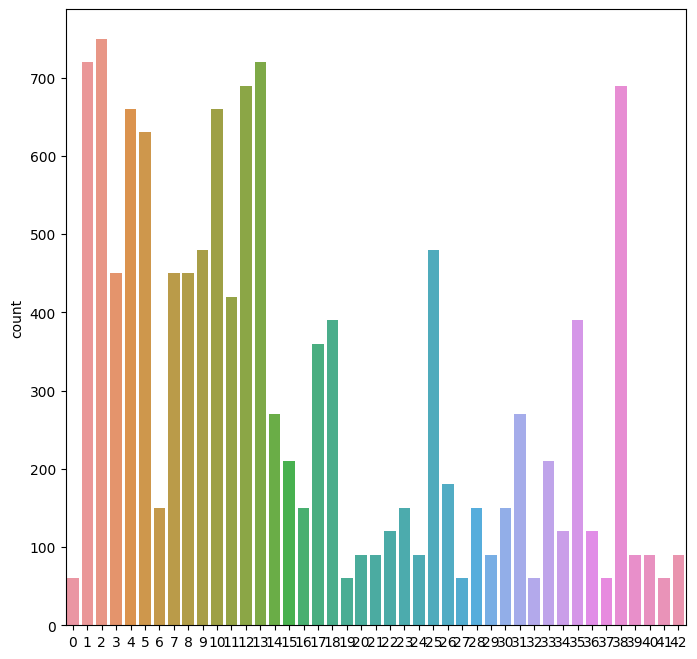

In [10]:
import seaborn as sns
plt.figure(figsize=(8,8))
sns.countplot(x=test_labels)

In [11]:
# Balanced accuracy computation
from sklearn.metrics import accuracy_score, balanced_accuracy_score
metrics = {
    "accuracy": accuracy_score,
    "balanced_accuracy": balanced_accuracy_score
}
training_metrics = eval_metrics(softmax_classifier, training_images, training_labels, 256, metrics, desc="Training Eval")
test_metrics = eval_metrics(softmax_classifier, test_images, test_labels, 256, metrics, desc="Test Eval")
print(f"Training metrics: {training_metrics}")
print(f"Test metrics: {test_metrics}")

Training Eval:   0%|          | 0/136 [00:00<?, ?it/s]

Test Eval:   0%|          | 0/50 [00:00<?, ?it/s]

Training metrics: {'accuracy': 0.4853875111353775, 'balanced_accuracy': 0.396651241620066}
Test metrics: {'accuracy': 0.4267616785431512, 'balanced_accuracy': 0.3232753920610341}


### What now?

They are two possibilities to go forward:

1. We trust in our current model, and we decide to fine-tune hyperparameters such as the batch size or the learning rate. This will require the use of a validation set to find optimal parameters.
2. We decide that a linear classifier acting directly on pixels is probably not that great of an idea to begin with, and we decide to go deeper!

Guess what, we'll go for option 2!

## Going Deeper: Multi-Layer Classifier

In this section, we'll redo much of the same work as for the single layer classification but, now that we know how things work under the hood, we'll rely a lot more on PyTorch to do things for us!

Our first model was nothing else than a softmax activation function stacked on top of a linear layer. The next one will exploit the same idea by stacking multiple layers on top.

The architecture will be as follows:

- Input $x$ of shape (B,32,32,3)
- Layer 1: Linear layer (aka fully-connected) with 100 neurons with biases, followed by ReLU activation ($32*32*3*100 + 100$ learnable weights)
- Layer 2: Linear layer with 75 neurons with biases, followed by ReLU activation ($100*75+75$ learnable weights)
- Output Layer: Linear layer with 43 neurons with biases followed by softmax activation ($75*43+43$ learnable weights)

Where $B$ is the batch size.




### PyTorch, batteries included

This time around, we will be using PyTorch's built-in layers, instead of creating them by hand like the first time. For reference, we could have simply implemented our previous model as:

```
softmax_classifier = nn.Sequential(nn.Flatten(), nn.Linear(32*32*3, 43), nn.Softmax())
```

We will also keep relying on the GPU for our model's computation using `.cuda()` to move tensor to the GPU.

Start the following cell to start training the model, and take your time to go over the code. There are no new concept, but this is now implemented using more of PyTorch's utilities.


In [12]:
from tqdm.notebook import tqdm

# PyTorch has utilities for dealing with datasets that extend its Dataset class
# It will be able to automatically load in batches and in parallel.
# In this toy example, the whole dataset fits in memory, but in most application,
# the whole dataset can weight 100GB+, so loading it in parallel makes a big difference.
class TrafficSignsDataset(torch.utils.data.Dataset):
  def __init__(self, path):
    images, labels = load_data(path)
    images = images.transpose((0,3,1,2)) # PyTorch expects image data in (channel,height,width) format instead of the usual (height,width,channel)
    self.images = torch.from_numpy(images).cuda() # Send data to GPU memory
    self.labels = torch.from_numpy(labels).cuda()
  def __len__(self):
    return len(self.images)
  def __getitem__(self, idx):
    return self.images[idx], self.labels[idx]

# Training loop
batch_size = 256
training_dataset = TrafficSignsDataset(traffic_signs_dir / "train.p")
validation_dataset = TrafficSignsDataset(traffic_signs_dir / "valid.p")
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

def predict_batch(model, batch_images, no_grad: bool):
  if no_grad:
    with torch.no_grad():
      class_probs = model(batch_images)
  else:
      class_probs = model(batch_images)
  class_labels = torch.argmax(class_probs, dim=1)
  return class_probs, class_labels

def eval_metrics(pred_labels, true_labels, prefix):
    metrics = {
      f"{prefix}accuracy": accuracy_score,
      f"{prefix}balanced_accuracy": balanced_accuracy_score
    }
    return { name: metric_fn(true_labels,pred_labels) for name, metric_fn in metrics.items() }

def train_model(model, training_loader, validation_loader, num_epochs, learning_rate):
  # Loss, optimizer and metrics
  loss_function = torch.nn.NLLLoss() # Negative Log-Likelihood loss function
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # We'll use a built-in optimizer implementation this time
  pbar = tqdm(range(num_epochs),desc="Epochs")
  for epoch in pbar:
    # Training
    train_losses = []
    train_true_labels = []
    train_pred_labels = []
    for batch_idx, (batch_images, batch_labels) in enumerate(training_loader):
      # Loss computation
      class_probs, class_labels = predict_batch(model, batch_images, no_grad=False)
      class_log_probs = torch.log(class_probs+1e-7)
      train_true_labels.append(batch_labels.cpu().numpy())
      train_pred_labels.append(class_labels.cpu().numpy())
      loss = loss_function(class_log_probs, batch_labels)
      train_losses.append(loss.item())
      # SGD Step
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    # Evaluation
    # Because Google lets us use pretty big GPUs for free,
    # we can predict the whole validation set at once!
    # This if of course almost never possible on larger datasets and in practice
    # we'd have to use a validation dataloader like for the training set
    _, val_class_labels = predict_batch(model, validation_dataset.images, no_grad=True)
    val_metrics = eval_metrics(
        val_class_labels.cpu().numpy(), # Send results GPU -> CPU memory
        validation_dataset.labels.cpu().numpy(),
        prefix="val_")
    train_metrics = eval_metrics(
        np.hstack(train_pred_labels),
        np.hstack(train_true_labels),
        prefix="train_")
    train_metrics["train_loss"] = np.mean(train_losses)
    pbar.set_postfix({**train_metrics, **val_metrics})

# Define the model
deep_softmax_classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32*32*3, 100), nn.ReLU(),
    nn.Linear(100, 75), nn.ReLU(),
    nn.Linear(75, 43), nn.Softmax(dim=1),
).cuda() # Send model to GPU memory

# Start training
train_model(deep_softmax_classifier, training_loader, validation_loader, num_epochs=150, learning_rate=1e-2)

Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

The validation accuracy should now be closer to 85%, which is a nice improvement! You're also probably observing a much higher training accuracy, which is a sign of overfitting!

Let's see if we can do even better if we stop considering all pixels independently: enter convolutions!

## Making things more Convoluted

Now that we are familiar with Linear layers, it's time to discover another type of layer: the extremely popular Convolutional Layer.

We will use these layers as a "feature extractor":

- Instead of using `Flatten` directly on the input pixels like we've done so far, these pixels will first be pre-processed by a few Conv layers, and we will flatten their output to a (B,512) vector
- The next layers will be the usual Linear layers, the only difference is that they don't operate on raw pixels anymore.

You can start out by adding 2 Linear layers and train the model. You should get very good training performance, but your model will likely overfit. Your job for assignment 1 will be to tweak both the architecture and the learning strategy in order to improve this.

In [13]:
# A typical CNN classifier
# We will discuss how this works in next week's class.
# For this assignment, use it as-is
# If you know Convolutional layers already, feel free to tweak it as much as you want
# but it's not necessary to complete the assignment!
feature_extractor = nn.Sequential(
    nn.Conv2d(3, 24, kernel_size=(6,6)), nn.ReLU(),
    nn.Conv2d(24, 36, kernel_size=(6,6)), nn.ReLU(),
    nn.Conv2d(36, 48, kernel_size=(4,4), stride=2), nn.ReLU(),
    nn.Conv2d(48, 64, kernel_size=(4,4), stride=2), nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(2,2), stride=2), nn.ReLU(),
)

conv_classifier = nn.Sequential(
    feature_extractor, # Extracts useful features
    nn.Flatten(), # Flatten all features into a single vector of dim (B,512)
    nn.Linear(512, 256), nn.ReLU(),
    nn.Linear(256, 43), nn.Softmax(dim=1), # TODO: Your layers go here
).cuda() # Send model to GPU memory

# Start training
train_model(conv_classifier, training_loader, validation_loader, num_epochs=100, learning_rate=3e-2)

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


## Assignment (Part One - Classification)

Your assignment is to build on the last model of this notebook to further improve
performance. There are several ways you can improve what we have done so far:

- **Model Architecture**: Add more layers or remove some. If you're not familiar with Convolutional Layers, leave the feature extractor part untouched.
- **Regularization**: Early Stopping, Dropout layers, Batch Normalization, ...
- **Data Augmentation**: Dynamically modify training inputs in ways that don't change the output class that should be predicted, so that the classifier learns to deal with variations in the input. There are hundreds of ways to proceed, eg. by changing contrast, lightly blurring images, flipping them horizontally, taking crops, adding light noise on them, ... Be creative! A combination of search engine use and the `transform` module of the `torchvision` library might be very helpful for this. You can implement this in a flexible way by simply adding an `augment(x)` functiont that applies a random augmentation on a batch `x` and call it inside the training loop.
- **Hyperparameter Tuning**: Try to tweak the learning rate and batch size, using the validation set performance to guide your search. You can also experiment with the parameters of the SGD optimizer, or even try different optimizers altogether.

You should aim the best possible accuracy on the test set (95%+ is a good milestone). Of course, you should not use performance on the test set to tune your model, only the validation set. The test set should only be touched once you're satisfied of the performance of your model on the training and validation sets.

Once you're satisfied with your model, **answer the following questions by adding code and text cells below these instructions.**

- Show at least 5 test samples where your model guesses the wrong class. What are the 5 most probable classes according to your model for these examples?
- Are there classification mistakes that are more common than others? To assess this, plot a [confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html). Are these mistakes similar to mistakes a human could do?
- Show the learning curves (loss values evolution with training epochs) on training and validation sets. What do these curve tell you?

Once you're ready to submit, create an individual code cell at the end of this notebook. This cell should be self-contained and create an instance of your model, restore your saved weights, and make predictions on the test set. For instructions on how to save/restore weights, see the [PyTorch Documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

Zip your final notebook along with your model's weights and upload your solution on Moodle. The file size limit is 250MB, but your model should be much smaller!


In [52]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import random
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss
import numpy as np

class RoadSignDataset(torch.utils.data.Dataset):
    """Dataset class for handling traffic sign images."""
    def __init__(self, dataset_path):
        super().__init__()
        self.data, self.targets = load_data(dataset_path)
        self.data = self.data.transpose((0, 3, 1, 2))  # Convert to (C,H,W) format.
        self.data = torch.from_numpy(self.data).cuda()
        self.targets = torch.from_numpy(self.targets).cuda()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]

def select_random_transformation():
    """Select a random image transformation."""
    options = [
        transforms.RandomAdjustSharpness(2),
        transforms.RandomPerspective(0.6, p=1.0),
        transforms.RandomErasing(),
        transforms.ColorJitter(0.8, 0.1, 0.5, 0)]
    return random.choice(options)

def batch_prediction(model, images, disable_grad):
    """Make a prediction for a batch of images."""
    context = torch.no_grad() if disable_grad else dummy_context()
    with context:
        probabilities = model(images)
        predicted = torch.argmax(probabilities, dim=1)
    return probabilities, predicted

def calculate_metrics(predicted, actual, prefix):
    """Calculate and return evaluation metrics."""
    metrics_dict = {
        f"{prefix}accuracy": accuracy_score,
        f"{prefix}balanced_accuracy": balanced_accuracy_score
    }
    return {name: func(actual, predicted) for name, func in metrics_dict.items()}

def train_network(network, train_loader, validate_loader, epochs, rate):
    """Main training loop for the network."""
    criterion = nn.CrossEntropyLoss()  #Cross-Entropy Loss
    optimizer = torch.optim.Adam(network.parameters(), lr=rate)  #Adam optimizer
    progress = tqdm(range(epochs), desc="Training Progress")
    losses, validate_losses = [], []

    for epoch in progress:
        network.train()
        batch_losses, true_labels, predicted_labels = [], [], []

        for images, labels in train_loader:
            augmented_images = select_random_transformation()(images)
            probabilities, predictions = batch_prediction(network, images, False)
            loss = criterion(torch.log(probabilities+1e-7), labels)  # Modified to use Cross-Entropy Loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            true_labels.append(labels.cpu().numpy())
            predicted_labels.append(predictions.cpu().numpy())

        network.eval()
        validate_probs, validate_labels = batch_prediction(network, validate_loader.dataset.data, True)

        # Ensure true_labels and predicted_labels are not empty and are lists of arrays
        if true_labels and predicted_labels:
            concatenated_true_labels = np.concatenate(true_labels) if len(true_labels) > 1 else true_labels[0]
            concatenated_predicted_labels = np.concatenate(predicted_labels) if len(predicted_labels) > 1 else predicted_labels[0]
        else:
            concatenated_true_labels = np.array([])
            concatenated_predicted_labels = np.array([])

        train_metrics = calculate_metrics(concatenated_predicted_labels, concatenated_true_labels, "train")
        validate_metrics = calculate_metrics(validate_labels.cpu().numpy(), validate_loader.dataset.targets.cpu().numpy(), "validate")
        progress.set_postfix({**train_metrics, **validate_metrics})

        losses.append(np.mean(batch_losses))
        validate_losses.append(log_loss(validate_loader.dataset.targets.cpu().numpy(), validate_probs.cpu().numpy()))
    return network, losses, validate_losses


class dummy_context:
    """A no-operation context manager."""
    def __enter__(self): pass
    def __exit__(self, *args): pass

# Neural network architecture
feature_extractor = nn.Sequential(
    nn.Conv2d(3, 24, kernel_size=6), nn.ReLU(),
    nn.Conv2d(24, 36, kernel_size=6), nn.ReLU(),
    nn.Conv2d(36, 48, kernel_size=4, stride=2), nn.ReLU(),
    nn.Conv2d(48, 64, kernel_size=4, stride=2), nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=2, stride=2), nn.ReLU(),
)

classifier_network = nn.Sequential(
    feature_extractor,
    nn.Flatten(),
    nn.Linear(512, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(100, 75),
    nn.BatchNorm1d(75),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(75, 43),
    nn.Softmax(dim=1)
).cuda()

# Training configuration
batch_size = 256
epochs = 100
learning_rate = 1e-3
train_dataset = RoadSignDataset(traffic_signs_dir / "train.p")
validate_dataset = RoadSignDataset(traffic_signs_dir / "valid.p")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size)

# Train the classifier
trained_network, training_losses, validation_losses = train_network(
    classifier_network, train_loader, validate_loader, epochs, learning_rate
)

# Save the trained network's state
torch.save(trained_network.state_dict(), 'tfsc_model.pt')


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]

1.9780342684851753
0.5621503293514252
0.2252649858042046
0.12678091001731379
0.08559569837870422
0.06361503901856917
0.050173061906739515
0.042147165826625296
0.03607951944211015
0.03457250757211888
0.03170466713469337
0.020473094839878657
0.02186933561331696
0.026240770687797555
0.022910775282178764
0.018532158434391023
0.02030591293134623
0.021568606624862662
0.011988187379514178
0.008211769073063301
0.007889613173729567
0.008447660861053953
0.019946841081535376
0.019605577926806828
0.013335027191270556
0.013267986995547458
0.0177152941926141
0.010245424727219399
0.011262731313601964
0.010406650544178707
0.007456453725764597
0.004763817984214122
0.010781402080061122
0.013874890982104397
0.008508588378835056
0.011995469489893704
0.016973161017435984
0.013960630692438119
0.010389541630650423
0.004791387470646037
0.0038961304888491415
0.004662999713629553
0.006285306040835739
0.011689934917053
0.0120751064469072
0.010345995334770392
0.005230496697024339
0.003798852255783492
0.0066916157

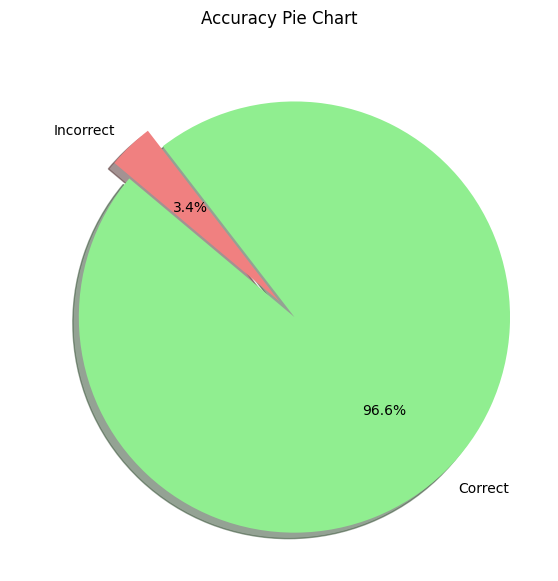

Number of correctly classified images: 12196
Number of incorrectly classified images: 434
Final accuracy: 96.56%


In [44]:

# Load the trained model's state and set it to evaluation mode
trained_network = classifier_network  # Ensure this is the same model structure used for training
trained_network.load_state_dict(torch.load('tfsc_model.pt'))
trained_network = trained_network.cuda()
trained_network.eval()

# Prepare the test dataset and loader
test_data = RoadSignDataset(traffic_signs_dir / "test.p")
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Initialize variables for tracking predictions and accuracy
predicted_labels_list = []
correct_predictions = 0
true_labels = []
misclassified_images = []

# Iterate through the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        output = trained_network(images)

        softmax_predictions = torch.log_softmax(output, dim=1)
        _, top_prediction = torch.max(softmax_predictions, dim=1)
        _, top_5_predictions = torch.topk(softmax_predictions, 5)

        # Convert predictions to CPU and numpy format for easier processing
        top_prediction = top_prediction.cpu().numpy()
        top_5_predictions = top_5_predictions.cpu().numpy()

        for idx, prediction in enumerate(top_prediction):
            predicted_labels_list.append(prediction)
            true_labels.append(labels[idx].item())  # Populate the true_labels list

            if labels[idx].item() == prediction:
                correct_predictions += 1
            else:
                misclassified_images.append((images[idx], labels[idx].item(), prediction, top_5_predictions[idx]))

total_images = len(true_labels)  # Total images is now the length of true_labels

# Calculate metrics
correct_count = correct_predictions
incorrect_count = total_images - correct_predictions
accuracy = correct_predictions / total_images if total_images > 0 else 0

# Create pie chart for accuracy
plt.figure(figsize=(7, 7))
labels = ['Correct', 'Incorrect']
sizes = [correct_count, incorrect_count]
colors = ['lightgreen', 'lightcoral']
explode = (0.1, 0)  # explode the first slice (Correct)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Accuracy Pie Chart')
plt.show()

# Print out the text results
print(f"Number of correctly classified images: {correct_count}")
print(f"Number of incorrectly classified images: {incorrect_count}")
print(f"Final accuracy: {accuracy:.2%}")



**QUESTION 1**

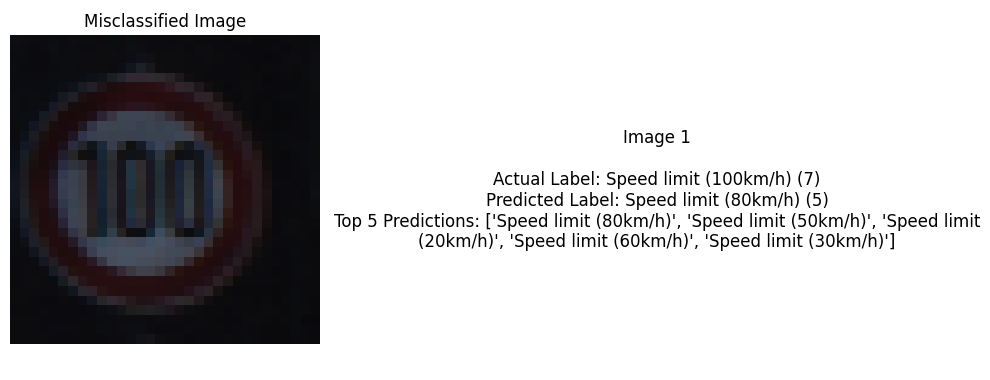

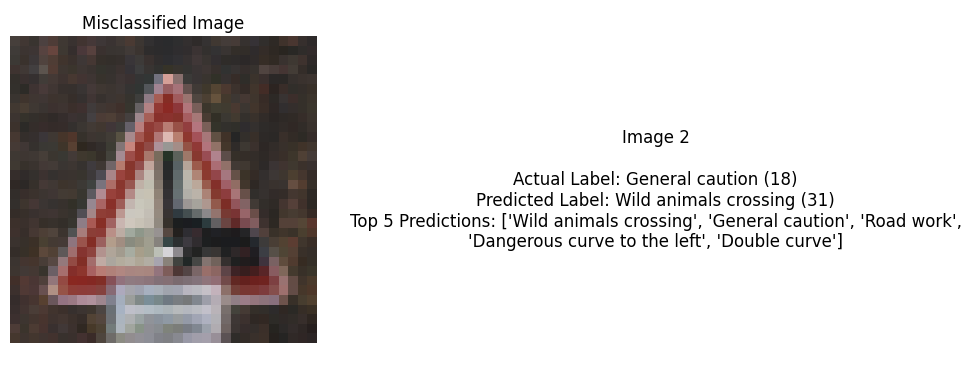

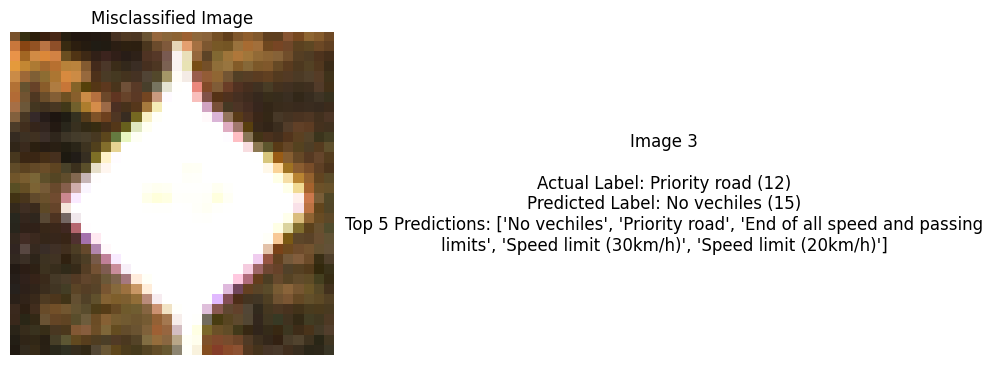

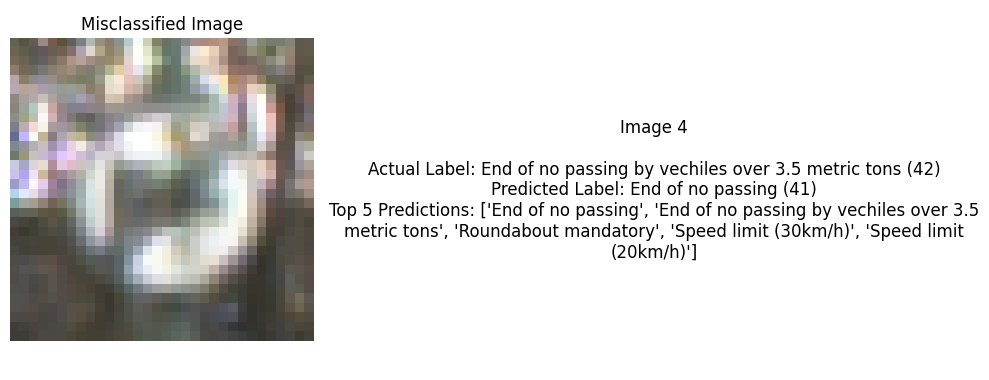

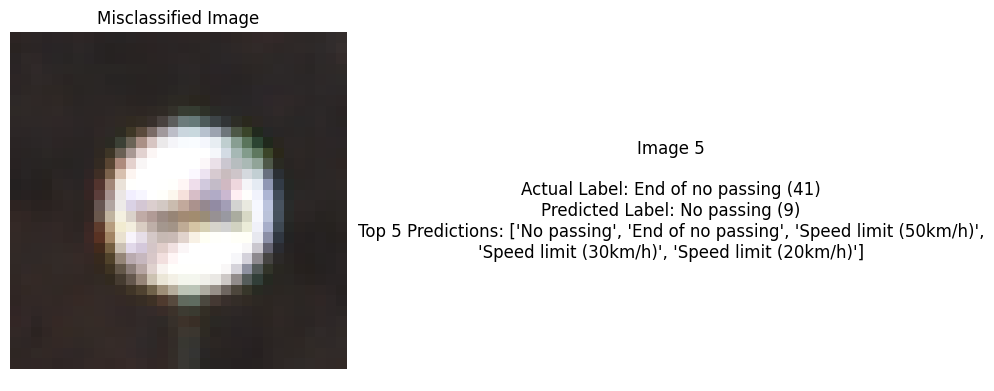

In [45]:

def get_sign_name(index, sign_names):
    try:
        return sign_names[index]
    except IndexError:
        return "Unknown"

# Display 5 random test samples that the model guessed wrong
num_samples = min(5, len(misclassified_images))
random_indices = np.random.choice(np.arange(len(misclassified_images)), size=num_samples, replace=False)

for idx, random_index in enumerate(random_indices):
    plt.figure(figsize=(10, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 3])

    # Extracting information about the misclassified image
    misclassified_image, true_label, predicted_label, top_5_predictions = misclassified_images[random_index]
    misclassified_image = misclassified_image.cpu().permute(1, 2, 0)  # Rearrange the tensor dimensions

    # Plotting the misclassified image
    ax0 = plt.subplot(gs[0])
    ax0.imshow(misclassified_image.numpy())
    ax0.set_title('Misclassified Image')
    ax0.axis('off')  # Turn off axis

    # Creating a text plot to display image information
    ax1 = plt.subplot(gs[1])
    ax1.axis('off')  # Turn off axis
    info_text = (f'Image {idx + 1}\n\n'
                 f'Actual Label: {get_sign_name(true_label, sign_names)} ({true_label})\n'
                 f'Predicted Label: {get_sign_name(predicted_label, sign_names)} ({predicted_label})\n'
                 f'Top 5 Predictions: {[get_sign_name(label, sign_names) for label in top_5_predictions]}')

    ax1.text(0.5, 0.5, info_text, ha='center', va='center', fontsize=12, wrap=True)

    plt.tight_layout()
    plt.show()


**QUESTION 2**

Considering the pixelated and occasionally dim nature of the images, it's plausible that a human might make identical errors, particularly when signs with similar shapes become challenging to differentiate due to factors like image resolution or darkness (for instance, triangular or circular signs may appear nearly identical). Nonetheless, under typical real-world conditions, barring situations with extreme fog, a human would generally be able to discern the differences between the signs.

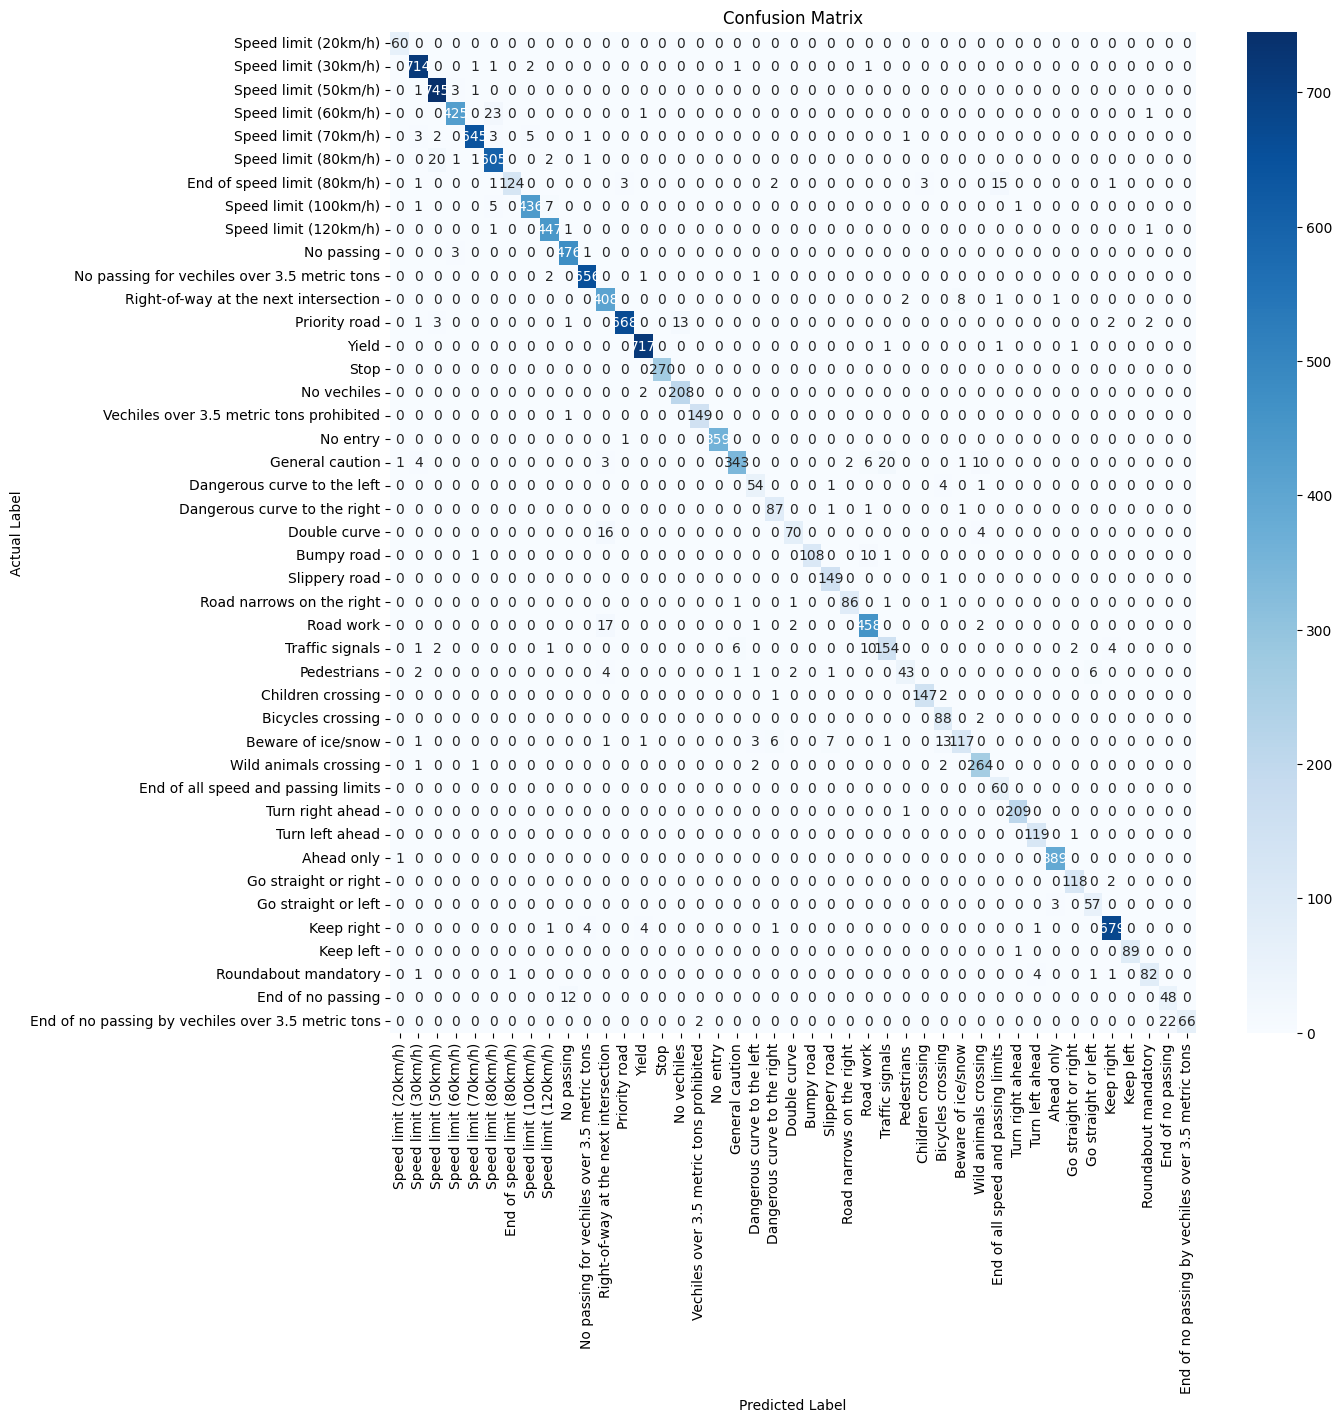

In [46]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels_list)

# 2. Plot the confusion matrix
plt.figure(figsize=(13,13))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=sign_names, yticklabels=sign_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()


**QUESTION 3**


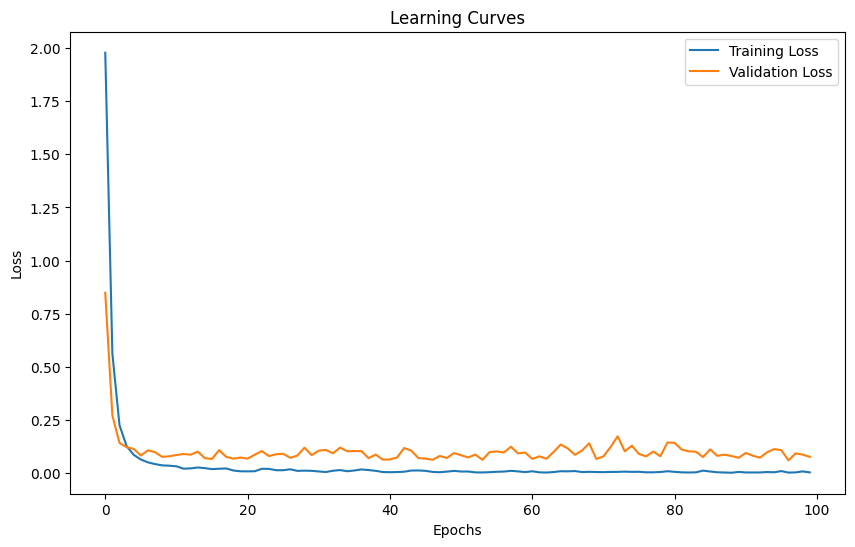

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [54]:
import os
print(os.getcwd())

/content
